# Final project--Yiyun (Rona) Luo

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from pyramid.arima import auto_arima
from numpy.linalg import inv
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR
#from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import coint

## 1. Data Clearance

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
print(os.getcwd())

/Users/admin/Desktop/Rona


In [4]:
path = r'/Users/admin/Downloads/full_history 2'
all_files = glob.glob(path + '/*.csv')
list_df = [pd.read_csv(f, index_col=0, usecols=['date','volume','adjclose']) for f in all_files]


In [5]:
for i in range(len(list_df)):
    list_df[i]=list_df[i].sort_index()

In [6]:
filename=[]
dirs= os.listdir(path)
for file in dirs:
     filename.append(file.replace('.csv',''))

In [7]:
for i in range(len(list_df)):
    list_df[i].columns=[filename[i]+'_volume',filename[i]+'_adjclose']    
    
#dfs = {'f'+str(i+1) : pd.read_csv(f) for i,f in enumerate(list_of_files)}

In [8]:
list_df_10yr=[]
for i in range(len(list_df)):
    if len(list_df[i].loc['2009-04-16':'2019-04-18'])==2520:
        list_df_10yr.append(list_df[i].loc['2009-04-16':'2019-04-18']) 

In [9]:
list_v_10=[]
for i in range(len(list_df_10yr)):
    if sum(list_df_10yr[i][list_df_10yr[i].columns[0]]<1000)/2520 <=0.05: #no more than 5% of volume less than 1000
        list_v_10.append(list_df_10yr[i])
        

In [10]:
print(len(list_df_10yr),len(list_v_10))

3787 3205


In [11]:
#less then 5% missing value in price
#missing_values = ['n/a','na','','NA','N/A']
list_m_10yr=[]
for j in range(len(list_v_10)):
    if (sum(list_v_10[j][list_v_10[j].columns[1]]==0)+ 
        sum(list_v_10[j][list_v_10[j].columns[1]].isnull()))/2520<0.05:
        list_m_10yr.append(list_v_10[j])

In [12]:
len(list_m_10yr)

3205

In [13]:
clean_list= list_m_10yr.copy()
import re

In [14]:
all_df = pd.concat(list_m_10yr, axis=1, join='inner')
print(all_df.shape)
print(all_df.isnull().sum().sum())


(2520, 6410)
0


In [15]:
price_df= all_df[all_df.columns.drop(list(all_df.filter(regex='volume')))]
print(price_df.shape)


(2520, 3205)


In [16]:
price_df.head(3)


,CSCO_adjclose,BIOS_adjclose,NZF_adjclose,UNT_adjclose,GPL_adjclose,SBGI_adjclose,UFCS_adjclose,BNY_adjclose,PPA_adjclose,ISSC_adjclose,...,SPTL_adjclose,LAC_adjclose,BLK_adjclose,BMO_adjclose,NXC_adjclose,SPXX_adjclose,PPL_adjclose,BWEN_adjclose,TIVO_adjclose,KEM_adjclose
date,,,,,,,,,,,,,,,,,,,,,
2009-04-16,14.295314,2.49,6.303655,27.700001,0.38,0.801760,15.413058,6.772310,11.458401,3.979697,...,21.832855,2.65,104.945930,19.379614,7.507971,4.858509,16.423471,78.199997,17.364796,1.313218
2009-04-17,14.224154,2.58,6.373877,28.629999,0.36,0.831455,15.246078,6.828747,11.502608,3.979697,...,21.501213,2.70,104.423515,19.740692,7.532633,4.867745,16.575489,83.199997,17.408474,1.343064
2009-04-20,13.686498,2.52,6.363070,25.549999,0.37,0.809184,13.815851,6.935977,11.087065,3.847273,...,21.829132,2.75,94.950691,18.337828,7.557287,4.692247,16.530445,78.400002,16.779568,1.432602


In [17]:
import seaborn as sns
#clean_price_df['HYD_adjclose'].plot()


In [18]:
def ts_clean(s):
    start_ts = s[s.notna()].index[0]
    end_ts = s[s.notna()].index[-1]
    s = s.loc[start_ts:end_ts]
    s = s.where(s.pct_change().abs().ge(0.5)==False,np.nan)
    s = s.interpolate()
    #s = s.fillna(0)
    return s

In [19]:
%%time
output = []
for series in price_df.columns:
    cleaned_series = ts_clean(price_df[series])
    output.append(cleaned_series)
    

CPU times: user 14.3 s, sys: 1.04 s, total: 15.3 s
Wall time: 16.8 s


In [20]:
clean_price_df = pd.concat(output,ignore_index=False,keys=price_df.columns,axis=1)
#clean_price_df

In [21]:
c_logre_df=np.log(clean_price_df/clean_price_df.shift())


In [22]:
c_logre_df=c_logre_df.iloc[0:-1,]

## 2 Asset Selection


### 2.1 highest sharp ratio

In [75]:
#rolling window size = 252
rolling_m=[]
rolling_v=[]
for i in c_logre_df.columns:
    mean_ro = c_logre_df[i].rolling(252).mean().shift() 
    std_ro = c_logre_df[i].rolling(252).std(ddof = 0).shift()
    #logre[i].pct_change.rolling(21).std().shift()
    #pd.rolling_std(logre[i],window=21) * np.sqrt(21)
    rolling_m.append(mean_ro)
    rolling_v.append(std_ro)

rolling_m1 = pd.concat(rolling_m,ignore_index=False,keys=c_logre_df.columns,axis=1)
rolling_v1 = pd.concat(rolling_v,ignore_index=False,keys=c_logre_df.columns,axis=1)

In [76]:
sr=rolling_m1/rolling_v1

### 2.21 highest Mean Return of AR forcast

In [86]:
#assets selection
# h=5
# m=252
# T=2520
# num_w=int((T-m)/h)
lnum=0
picksharp=[]
for i in range(253,sr.shape[0],h):
    picksharp.append(sr.iloc[i,:].sort_values(ascending=False)[:30].index)
    lnum=lnum+1

In [89]:
pickar=picksharp

In [78]:
def ar_predict(train,h):
    model = AR(train)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train)+h-1, dynamic=False)
    return predictions

In [27]:
#Auto ARIMA
def autoarima_predict(train,h):
    model = auto_arima(train, trace=False,error_action='ignore', suppress_warnings=True)
    model.fit(train)

    forecast = model.predict(n_periods=h)
#     forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])
    return forecast

In [73]:
#ARIMA MODEL
#h=5 #forcast horizon is 5 days
lnum=0 #counting loop number
pickarima=[]
# for i in range(253,2520,5):
for i in range(253,254):
    arima_forcast_select=[]
    for j in range(len(picksharp[0])): #
        train=c_logre_df[picksharp[lnum][j]].iloc[(i-252):(i)]
#         print(autoarima_predict(train,h))
        arima_forcast_select.append(autoarima_predict(train,h))
    stock60_return=np.transpose(arima_forcast_select) #row as daily return, col as the 60 stocks
#         stock60_return.mean(0) #col mean: average return for each stock
    colidx=np.argsort(stock60_return.mean(0))[-30:]
    pickarima.append(picksharp[lnum][colidx])
    lnum=lnum+1

In [79]:
##AR Model
#h=5 #forcast horizon is 5 days
 #counting loop number
pickar=[]
lnum=0
for i in range(253,2520,5):
# for i in range(253,255):
    ar_forcast=[]
    for j in range(len(picksharp[0])): #
        train=c_logre_df[picksharp[lnum][j]].iloc[(i-252):(i)]
#         print(autoarima_predict(train,h))
        ar_forcast.append(ar_predict(train,h))
    stock60_return=np.transpose(ar_forcast) #row as daily return, col as the 60 stocks
#  stock60_return.mean(0) col mean: average return for each stock
    colidx=np.argsort(stock60_return.mean(0))[-30:]
    pickar.append(picksharp[lnum][colidx])
    lnum=lnum+1

### 2.2.2 Cointegration, pair trading selection

In [637]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.02:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [638]:
# c_logre_df[pickar[0]]

In [643]:
findpair=find_cointegrated_pairs(c_logre_df[pickar[0]].iloc[1:253])

## 3 Portfolio Optimization

### 3.1 AR model for prior

In [29]:
#likelihood
wnum=0
mu_likelihood=[]
sigma_likelihood=[]
sigma_likelihood2=[]
for i in range(253,2520,5):
    mu_likelihood.append(c_logre_df[pickar[wnum]].iloc[(i-252):(i)].mean(axis=0).values)
    sigma_likelihood.append(c_logre_df[pickar[wnum]].iloc[(i-252):(i)].std(axis=0).values)
    sigma_likelihood2.append(c_logre_df[pickar[wnum]].iloc[(i-252):(i)].cov()*1.0/252.0)
    wnum=wnum+1
    if wnum==453:
        break

In [31]:
wnum=0
mu_prior=[]
sigma_prior=[]
sigma_prior2=[]
#h=5
for i in range(253,2520,h):
    ar_forcast=[]
    for j in range(len(pickar[0])):
        train=c_logre_df[pickar[wnum][j]].iloc[(i-252):(i)].values
        ar_forcast.append(ar_predict(train,h))
    stock30_return=np.transpose(ar_forcast)
    test=c_logre_df[pickar[wnum]].iloc[(i):(i+h)]
    stock30_return=pd.DataFrame(stock30_return)
    stock30_return.columns=test.columns
    stock30_return.index=test.index
    residual_ar=test.mean(axis=0)-stock30_return
    mu_prior.append(np.mean(stock30_return,axis=0))
#     sigma_prior.append(np.var(residual_ar,axis=0))
    
    sigma_prior2.append(residual_ar.cov())
    wnum=wnum+1
    if wnum==453:
        break

In [32]:
#Black-Litterman model
tau=1.0
mu_bl_ar=[]
sigma_bl_ar=[]
for wnum in range(len(pickar)-1):
    a=inv(inv(sigma_likelihood2[wnum])+inv(sigma_prior2[wnum]))
    b=np.dot(inv(sigma_likelihood2[wnum]),mu_likelihood[wnum])+np.dot(inv(sigma_prior2[wnum]),mu_prior[wnum])
    mu_transit=np.dot(a,b)
    sigma_transit=a
    mu_bl_ar.append(mu_transit)
    sigma_bl_ar.append(sigma_transit)

### 3.2 VAR model for prior

In [33]:
logre_nna=c_logre_df.iloc[1:]

In [173]:
#likelihood
h=5
m=252
w_mean=[]
w_cov=[]
for w in range(len(pickar)-1):
    data=logre_nna[pickar[w]].iloc[int(w*h):int(m+w*h)]
    w_avg=data.mean(axis = 0)  # iid window mu
    wcov= data.cov()  #iid window sigma
    w_mean.append(w_avg)
    w_cov.append(wcov)

In [174]:
h=5
m=252
fore_mean=[]
fore_result=[]
for w in range(len(pickar)-1):
    data=logre_nna[pickar[w]].iloc[int(w*h):int(m+w*h)]
    model = VAR(data)
    model_result = model.fit(1)
    output = model_result.forecast(model_result.y,steps=h)
    forecast_mean=np.mean(np.array(output), axis=0)  # forecast mu 
    #residual=np.std(np.array(output), axis=0)
    fore_result.append(output)
    fore_mean.append(forecast_mean)

In [175]:
## calculate sigma prior
#sigma prior = cov(residual)
h=5
m=252
real=[]
residual=[]
for w in range(len(pickar)-1): 
    recorded = logre_nna[pickar[w]].iloc[int(w*h+m):int(m+w*h+h)]
    real.append(recorded)

for w in range(len(pickar)-1): 
    diff = real[w].values-fore_result[w]
    residual.append(diff)

In [176]:
#con't
residual_cov=[]
for w in range(len(pickar)-1): 
    cov_resi= pd.DataFrame(residual[w]).cov()
    residual_cov.append(cov_resi)

In [1]:
#Apply Black litterman model

tau = 1
mu_bl_VAR=[]
sigma_bl_VAR=[]
for i in range(len(pickar)-1):
    mu_b = np.dot((inv(inv(tau*w_cov[i])+inv(residual_cov[i]))),
                  (np.dot(inv(tau*w_cov[i]),w_mean[i])+np.dot(inv(residual_cov[i]),fore_mean[i])))
    sigma_b = inv(inv(tau*w_cov[i])+inv(residual_cov[i]))
    mu_bl_VAR.append(mu_b)
    sigma_bl_VAR.append(sigma_b)
    
    

### 4. Portfolio Optimization

### 4.1 optimization with AR

In [271]:
#portfolio optimization Black-Litterman model
h=5
m=252
opt_weight_AR=[]

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


for num_w in range(len(pickar)-1): #len(pickar)
       
    mu=pd.Series(mu_bl_ar[num_w],index=pickar[num_w])
    SS=pd.DataFrame(sigma_bl_ar[num_w])
    SS.columns=pickar[num_w]
    SS.index=pickar[num_w]
    S=SS

    # Optimise for maximal Sharpe ratio
    ef = EfficientFrontier(mu, S)
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
        
    opt_weight_AR.append(cleaned_weights)


In [272]:
opt_return_AR=[]
opt_return_AR_daily=[]
for i in range(len(opt_weight_AR)):
    daily_return=c_logre_df[pickar[num_w]].iloc[int(i*h+m+1):int(m+i*h+h+1)]
    m_return = daily_return.sum(axis=0)
    opt_return_AR.append(np.dot(list(opt_weight_AR[i].values()),m_return))
    opt_return_AR_daily.append(np.dot(daily_return,list(opt_weight_AR[i].values())))

In [119]:
opt_cu_AR=pd.DataFrame(opt_return_AR)
opt_cu_AR.columns=['opt_return']
opt_cu_AR['cumu_cu_AR']=opt_cu_AR.opt_return.cumsum(axis = 0)

In [200]:
opt_return_AR_daily_flat = [item for sublist in opt_return_AR_daily for item in sublist]
opt_return_AR_daily_flat=pd.Series(opt_return_AR_daily_flat,index=clean_price_df.index[253:(253+len(opt_return_AR_daily_flat))])

In [202]:
opt_return_AR_daily_flat.to_csv('opt_return_AR_daily_flat.csv')

In [113]:
#record h=5 result
# opt_cu_AR_h5=opt_return_AR
# opt_cu_AR_flat_h5=opt_return_AR_daily

### 4.2 Portfolio optimization with prior info from VAR

In [3]:
#portfolio optimization Black-Litterman model
h=5
m=252
opt_weight_VAR=[]

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


for num_w in range(len(pickar)-1): #len(pickar)
    
   
    mu=pd.Series(mu_bl_VAR[num_w],index=pickar[num_w])
    SS=pd.DataFrame(sigma_bl_VAR[num_w])
    SS.columns=pickar[num_w]
    SS.index=pickar[num_w]
    S=SS

    # Optimise for maximal Sharpe ratio
    ef = EfficientFrontier(mu, S)
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
        
    opt_weight_VAR.append(cleaned_weights)

    

In [ ]:
opt_return_VAR=[]
opt_return_VAR_daily=[]
for i in range(len(opt_weight_VAR)):
    daily_return=c_logre_df[pickar[num_w]].iloc[int(i*h+m+1):int(m+i*h+h+1)]
    m_return = daily_return.sum(axis=0)
    opt_return_VAR.append(np.dot(list(opt_weight_VAR[i].values()),m_return))
    opt_return_VAR_daily.append(np.dot(daily_return,list(opt_weight_VAR[i].values())))

In [ ]:
opt_cu_VAR=pd.DataFrame(opt_return_VAR)
opt_cu_VAR.columns=['opt_return']
opt_cu_VAR['cumu_cu_VAR']=opt_cu_VAR.opt_return.cumsum(axis = 0)

In [ ]:
opt_return_VAR_daily_flat = [item for sublist in opt_return_VAR_daily for item in sublist]
opt_return_VAR_daily_flat=pd.Series(opt_return_VAR_daily_flat,index=clean_price_df.index[253:(253+len(opt_return_VAR_daily_flat))])

In [107]:
#record h=5 result
# opt_cu_VAR_h5=opt_cu_VAR
# opt_cu_VAR_flat_h5=opt_return_VAR_daily_flat

### 4.2 Portfolio optimization without prior info

In [124]:
# Without Black-Litterman model
h=5
m=252
opt_weight2=[]

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


for num_w in range(len(pickar)-1): #len(pickar)
    
    df=clean_price_df[pickar[num_w]].iloc[int(num_w*h+1):int(m+num_w*h+1)]
    mu = expected_returns.mean_historical_return(df)
    S = risk_models.sample_cov(df)
    # Calculate expected returns and sample covariance
   
#     mu=pd.Series(mu_bl[num_w],index=pickar[num_w])
#     SS=pd.DataFrame(sigma_bl[num_w])
#     SS.columns=pickar[num_w]
#     SS.index=pickar[num_w]
#     S=SS

    # Optimise for maximal Sharpe ratio
    ef = EfficientFrontier(mu, S)
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
        
    opt_weight2.append(cleaned_weights)

    

In [125]:
opt_return2=[]
for i in range(len(opt_weight2)):
    daily_return=c_logre_df[pickar[num_w]].iloc[int(i*h+m+1):int(m+i*h+h+1)]
    m_return = daily_return.sum(axis=0)
    opt_return2.append(np.dot(list(opt_weight2[i].values()),m_return))

In [126]:
opt_cu_df2=pd.DataFrame(opt_return2)
opt_cu_df2.columns=['opt_return2']
opt_cu_df2['cumu_re_opt2']=opt_cu_df2.opt_return2.cumsum(axis = 0)

In [127]:
return_noprior=[]
for i in range(len(opt_weight2)):
    daily_return=c_logre_df[pickar[i]].iloc[int(i*h+m+1):int(m+i*h+h+1)]
    m_return = daily_return.sum(axis=0)
    return_noprior.append(np.dot(daily_return,list(opt_weight2[i].values())))

noprior_daily_flat = [item for sublist in return_noprior for item in sublist]
noprior_daily_flat=pd.Series(noprior_daily_flat,index=clean_price_df.index[253:(253+len(noprior_daily_flat))])

In [99]:
#record h=5 result
# opt_cu_df2_h5=opt_cu_df2
# noprior_daily_flat_h5=noprior_daily_flat

In [171]:
# noprior_daily_flat.to_csv('noprior_daily_flat.csv')

## equally weighted

In [192]:
weight_eq=np.repeat(1.0/30.0,30)
eq_return=[]
eq_volatility=[]
eq_sharp_ratio=[]
eq_return_daily=[]
for num_w in range(len(pickar)-1):
    daily_return=c_logre_df[pickar[num_w]].iloc[int(num_w*h+m):int(m+num_w*h+h)]
    w_return = daily_return.sum(axis=0)
    returns = np.dot(weight_eq, w_return)
    eq_return_daily.append(np.dot(daily_return,weight_eq))
    eq_return.append(returns)

eq_return_daily_flat = [item for sublist in eq_return_daily for item in sublist]
eq_return_daily_flat=pd.Series(eq_return_daily_flat,index=clean_price_df.index[253:(253+len(eq_return_daily_flat))])

In [193]:
# eq_return_daily_flat.to_csv('eq_weight_daily_return.csv')

In [194]:
eq_return=pd.DataFrame(eq_return)
eq_return.columns=['eq_return']
eq_return['cusum']=eq_return.eq_return.cumsum(axis = 0)

## SP500

In [54]:
SP500 = pd.read_csv("SP500new.csv", usecols=['Date','Close'],index_col=0) 
SP500_10 = SP500.loc['2009-04-16':'2019-04-18']

In [55]:
SP500_logre=np.log(SP500_10/SP500_10.shift())

In [61]:
SP500_logre_rw = SP500_logre.rolling(5).sum().shift() 
plot_SP500_logre_rw=SP500_logre_rw.iloc[252::5,]
cumulative_SP500=[]
for i in range(len(plot_SP500_logre_rw)): #454?
    cumulative_SP500.append(sum(plot_SP500_logre_rw.Close.iloc[0:i+1]))

In [62]:
SP500_cu_df= pd.DataFrame(cumulative_SP500)
SP500_cu_df.columns = ['cumu_re_SP500']

## Recalculate accumalated return (net return)

In [128]:
def netreturn_func(weight_opt,price_dataframe,return_df):
    kappa=0.0005
    weight_opt=pd.DataFrame(weight_opt)
    
    #find stocks that haven't been selected in all windows, and named the name list as nonselect_stock
    nonselect_stock=list(set(price_dataframe.columns)-set(weight_opt.columns))
    
    #enlarge the weight matrix to be the same size of the price matrix and 
    weight_opt_allstock=pd.concat([weight_opt,pd.DataFrame(columns=nonselect_stock)])
    weight_opt_allstock = weight_opt_allstock[list(price_dataframe.columns)]
    
    weight_opt_allstock=weight_opt_allstock.fillna(0)
    
    last_price_w=price_dataframe.iloc[257::5]
    first_price_w=price_dataframe.iloc[258::5]
    
    
    netreturn=[]
    for numw in range(len(weight_opt)-1): #range(len(weight_BL)):
        weight_before=weight_opt_allstock.iloc[numw,:]
        weight_after=weight_opt_allstock.iloc[numw+1,:]
        price_before=last_price_w.iloc[numw,:]
        price_after=first_price_w.iloc[numw,:]
        Q_before=weight_before/price_before
        weight_before_rebalance=Q_before*price_after/(Q_before*price_after).sum()
        return_window=return_df.iloc[numw,0]
        netreturn.append( ((1-kappa*sum(abs(weight_after-weight_before_rebalance)))*(1+return_window))-1 )
        
    return netreturn

In [313]:
opt_netreturn=netreturn_func(opt_weight2,clean_price_df,opt_cu_df2) # net return no prior 

In [314]:
opt_netreturn=pd.DataFrame(opt_netreturn)
opt_netreturn.columns=['net_return_window']
opt_netreturn['cusum']=opt_netreturn.net_return_window.cumsum()

In [334]:
optAR_netreturn=netreturn_func(opt_weight_AR,clean_price_df,opt_cu_AR) # net return AR

In [335]:
optAR_netreturn=pd.DataFrame(optAR_netreturn)
optAR_netreturn.columns=['net_returnAR_window']
optAR_netreturn['cusum_AR']=optAR_netreturn.net_returnAR_window.cumsum()

## Plot

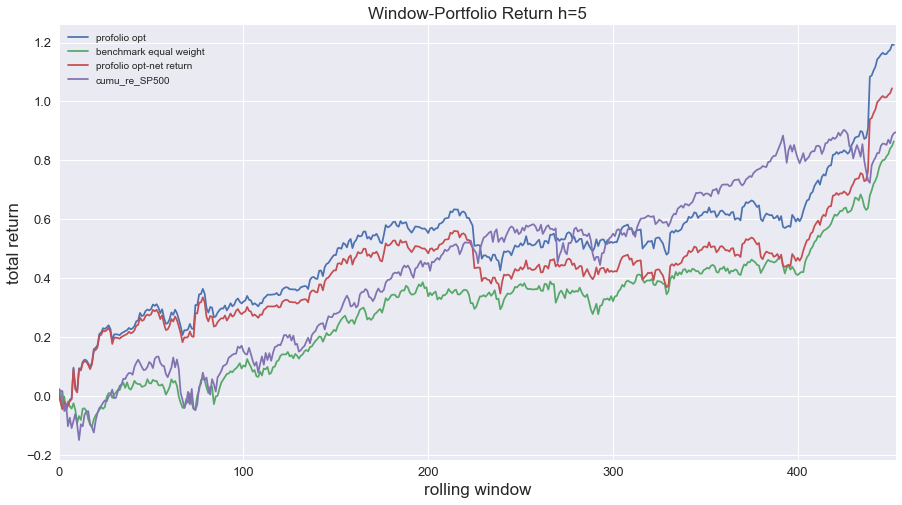

In [306]:
fig = plt.figure(figsize=(15,8))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
ax = fig.add_subplot(1, 1, 1)
opt_cu_df2.cumu_re_opt2.plot(ax=ax,label='profolio opt')
#opt_cu_VAR.cumu_cu_VAR.plot(ax=ax,label='profolio opt with BL and VAR')
#opt_cu_AR.cumu_cu_AR.plot(ax=ax,label='profolio opt with BL and AR')
eq_return['cusum'].plot(ax=ax,label='benchmark equal weight')
opt_netreturn.cusum.plot(ax=ax,label='profolio opt-net return')
SP500_cu_df.plot(ax=ax,label='SP500')
ax.legend()
ax.set_xlabel('rolling window',size=17)
ax.set_ylabel('total return',size=17)
ax.set_title('Window-Portfolio Return h=5',size=17)
ax.tick_params(axis="both", labelsize=13)
plt.show()

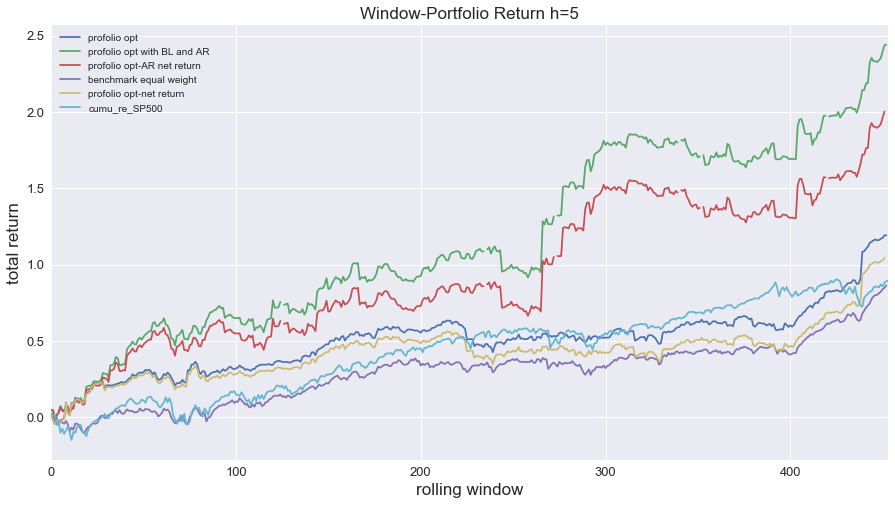

In [340]:
fig = plt.figure(figsize=(15,8))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
ax = fig.add_subplot(1, 1, 1)
opt_cu_df2.cumu_re_opt2.plot(ax=ax,label='profolio opt')
opt_cu_AR.cumu_cu_AR.plot(ax=ax,label='profolio opt with BL and AR')
optAR_netreturn.cusum_AR.plot(ax=ax,label='profolio opt-AR net return')
eq_return['cusum'].plot(ax=ax,label='benchmark equal weight')
opt_netreturn.cusum.plot(ax=ax,label='profolio opt-net return')
SP500_cu_df.plot(ax=ax,label='SP500')
ax.legend()
ax.set_xlabel('rolling window',size=17)
ax.set_ylabel('total return',size=17)
ax.set_title('Window-Portfolio Return h=5',size=17)
ax.tick_params(axis="both", labelsize=13)
plt.show()

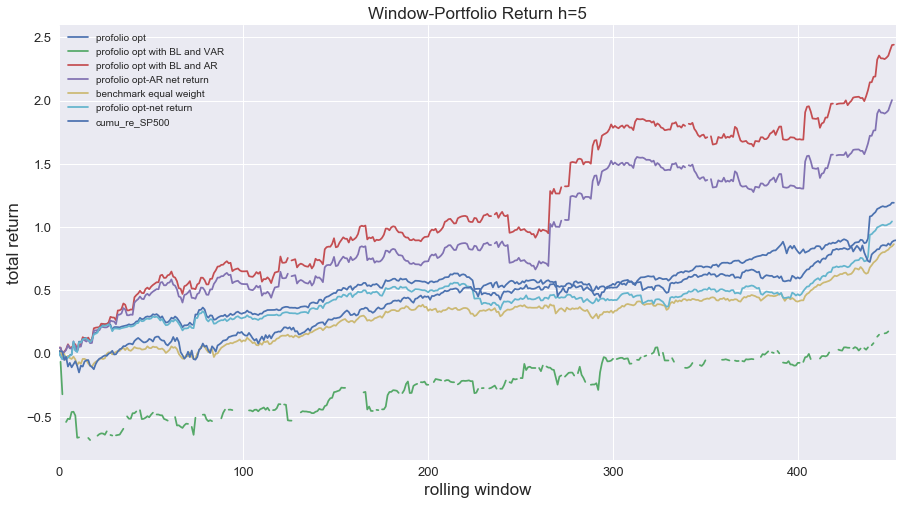

In [341]:
fig = plt.figure(figsize=(15,8))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
ax = fig.add_subplot(1, 1, 1)
opt_cu_df2.cumu_re_opt2.plot(ax=ax,label='profolio opt')
opt_cu_VAR.cumu_cu_VAR.plot(ax=ax,label='profolio opt with BL and VAR')
opt_cu_AR.cumu_cu_AR.plot(ax=ax,label='profolio opt with BL and AR')
optAR_netreturn.cusum_AR.plot(ax=ax,label='profolio opt-AR net return')
eq_return['cusum'].plot(ax=ax,label='benchmark equal weight')
opt_netreturn.cusum.plot(ax=ax,label='profolio opt-net return')
SP500_cu_df.plot(ax=ax,label='SP500')
ax.legend()
ax.set_xlabel('rolling window',size=17)
ax.set_ylabel('total return',size=17)
ax.set_title('Window-Portfolio Return h=5',size=17)
ax.tick_params(axis="both", labelsize=13)
plt.show()

## Turnover

In [303]:
def turnover_func(weight_opt,price_dataframe):
    weight_opt=pd.DataFrame(weight_opt)
    
    #find stocks that haven't been selected in all windows, and named the name list as nonselect_stock
    nonselect_stock=list(set(price_dataframe.columns)-set(weight_opt.columns))
    
    #enlarge the weight matrix to be the same size of the price matrix and 
    weight_opt_allstock=pd.concat([weight_opt,pd.DataFrame(columns=nonselect_stock)])
    weight_opt_allstock = weight_opt_allstock[list(price_dataframe.columns)]
    
    weight_opt_allstock=weight_opt_allstock.fillna(0)
    
    last_price_w=price_dataframe.iloc[257::5]
    first_price_w=price_dataframe.iloc[258::5]
    
    turnover=0
    addon=[]
    for numw in range(len(weight_opt)-1): #range(len(weight_BL)):
#         print(numw)
        weight_before=weight_opt_allstock.iloc[numw,:]
        weight_after=weight_opt_allstock.iloc[numw+1,:]
        price_before=last_price_w.iloc[numw,:]
        price_after=first_price_w.iloc[numw,:]
        Q_before=weight_before/price_before
        weight_before_rebalance=Q_before*price_after/(Q_before*price_after).sum()
#         addon.append(sum(abs(weight_after-weight_before_rebalance)))
        turnover=np.nansum([turnover,sum(abs(weight_after-weight_before_rebalance))])
        
        
    return turnover

In [258]:
eq_weight=pd.DataFrame(np.zeros((len(pickar)-1, clean_price_df.shape[1])),columns=clean_price_df.columns)
for row in range(eq_weight.shape[0]):
    eq_weight.iloc[row,:][pickar[row]]=1.0/30.0

In [305]:
print("no prior opt:",turnover_func(opt_weight2,clean_price_df))
#print("VAR opt:",turnover_func(opt_weight_VAR,clean_price_df))
print("AR opt:",turnover_func(opt_weight_AR,clean_price_df))
print("equal weight:",turnover_func(eq_weight,clean_price_df))

no prior opt: 295.32046893354726
AR opt: 864.4817915312317
equal weight: 219.34746207914387


### Calculation of mean returns, volatilities, Sharpe ratios, Sortino ratios, turnover and maximum drawdown in R file 

In [ ]:
# citation:
## https://plot.ly/ipython-notebooks/markowitz-portfolio-optimization/
## https://davistownsend.github.io/blog/Parallel_ts_fc_Dask/
## http://www.turingfinance.com/computational-investing-with-python-week-one/


In [ ]:
#END